# Diabetes or not: A Comprehensive Analysis of Diabetical Symptoms in Pima Indians Diabetes Database #

### by Brian Adhitya, Wyatt Howell, Brian Ko, Nishanth Selvakumar

### Introduction

Diabetes is a common and chronic condition characterized by high blood sugar levels. It occurs when the body can't produce enough insulin or can't use it effectively. Diabetes is a major global health concern, leading to complications like heart diseases, kidney issues, vision problems, and nerve damage. Lifestyle factors and genetics contribute to its development. Management involves medication, lifestyle changes, and regular monitoring. Due to its widespread impact, diabetes is a focus of ongoing research and public health efforts. 

This dataset provides insight into diabetic diagnosis based on certain health factors for women over the age of 21 of Pima Indian heritage. The Pima is a Native American group situated in southern Arizona, USA. The health factors include the number of pregnancies, glucose concentration (orally tested), blood pressure, skin thickness, BMI, diabetes pedigrees function, insulin level, and age. Understanding the health factors that are prevalent in diabetic patients is essential for developing treatment methods. Using these factors, we will be able to notice trends, patterns, and relationships and use these to predict the diabetic outcome of an undiagnosed patient and what preventative measures can be taken. 

Our Question: 
**Can we predict a patient's diagnosis of diabetes based on health factors such as blood pressure, BMI, pregnancies etc.?**

### Loading libraries

In [2]:
# ensuring analysis is reproducible
set.seed(9999)

# importing libraries
library(tidyverse)
library(repr)
library(janitor)
library(ggplot2)
library(tidymodels)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ──────

### Preeliminary exploratory data analysis

**1. Loading and cleaning the Dataset**

In [3]:
# Cleaning names and specifying categorical variable
diabetes <- read_csv("data/diabetes.csv") |>
            clean_names() |>
            mutate(outcome = as_factor(outcome)) |>
            mutate(diabetes = fct_recode(outcome, "Yes" = "1", "No" = "0")) |>
            select(-outcome)

# Displaying the data
head(diabetes)

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,0,33.6,0.627,50,Yes
1,85,66,29,0,26.6,0.351,31,No
8,183,64,0,0,23.3,0.672,32,Yes
1,89,66,23,94,28.1,0.167,21,No
0,137,40,35,168,43.1,2.288,33,Yes
5,116,74,0,0,25.6,0.201,30,No


**TABLE 1**

**2. Splitting into testing and training**

In [4]:
# splitting the diatabes data
diabetes_split <- initial_split(diabetes, prop = 0.75, strata = diabetes)

# training data
diabetes_training <- training(diabetes_split)

# testing data
diabetes_testing <- testing(diabetes_split)

# the data to be used
head(diabetes_training)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,85,66,29,0,26.6,0.351,31,No
1,89,66,23,94,28.1,0.167,21,No
5,116,74,0,0,25.6,0.201,30,No
10,115,0,0,0,35.3,0.134,29,No
4,110,92,0,0,37.6,0.191,30,No
1,103,30,38,83,43.3,0.183,33,No


**TABLE 2**

**3. Cleaning and wrangling data**

In [5]:
# Summarizing the age data
diabetes_summary_age <- diabetes_training |>
                        group_by(diabetes) |>
                        summarize(min_age = min(age, na.rm = TRUE),
                                max_age = max(age, na.rm = TRUE),
                                mean_age = mean(age, na.rm = TRUE))

# Summarizing the glucose level data
diabetes_summary_glucose <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_glucose = min(glucose, na.rm = TRUE),
                                      max_glucose = max(glucose, na.rm = TRUE),
                                      mean_glucose = mean(glucose, na.rm = TRUE))

# Summarize the pregnancies data
diabetes_summary_pregnancies <- diabetes_training |>
                            group_by(diabetes) |>
                            summarize(min_pregnancies = min(pregnancies, na.rm = TRUE),
                                      max_pregnancies = max(pregnancies, na.rm = TRUE),
                                      mean_pregnancies = mean(pregnancies, na.rm = TRUE))

# joining all the summaries into a dataframe
diabetes_summary <- full_join(diabetes_summary_age, diabetes_summary_glucose, by = "diabetes") |>
                    full_join(diabetes_summary_pregnancies, by = "diabetes")

# displaying the data
head(diabetes_summary)

diabetes,min_age,max_age,mean_age,min_glucose,max_glucose,mean_glucose,min_pregnancies,max_pregnancies,mean_pregnancies
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,21,81,31.27200,0,197,109.6560,0,13,3.320000
Yes,21,70,37.61692,0,199,141.6915,0,17,4.875622


**TABLE 3**

In [15]:
#Average glucose, blood pressure, bmi levels for number of pregnancies considered as a factor
diabetes_training_pregnant_stage <- diabetes_training |>
                            mutate(pregnancies = as_factor(pregnancies)) |>
                            group_by(pregnancies) |>
                            summarize(
                                average_glucose = mean(glucose),
                                average_bmi = mean(bmi),
                                average_blood_pressure = mean(blood_pressure))

diabetes_training_pregnant_stage

pregnancies,average_glucose,average_bmi,average_blood_pressure
<fct>,<dbl>,<dbl>,<dbl>
0,123.2093,34.55698,67.81395
1,112.4200,30.60400,67.68000
2,111.5250,30.77875,63.47500
3,126.9000,31.50000,67.48000
4,123.9318,31.70909,69.54545
5,118.4651,32.48837,75.93023
6,118.5854,29.90732,66.26829
7,137.8158,32.36842,69.34211
8,128.1379,30.86552,75.20690


**TABLE 4**

**4. Visualizing some key points**

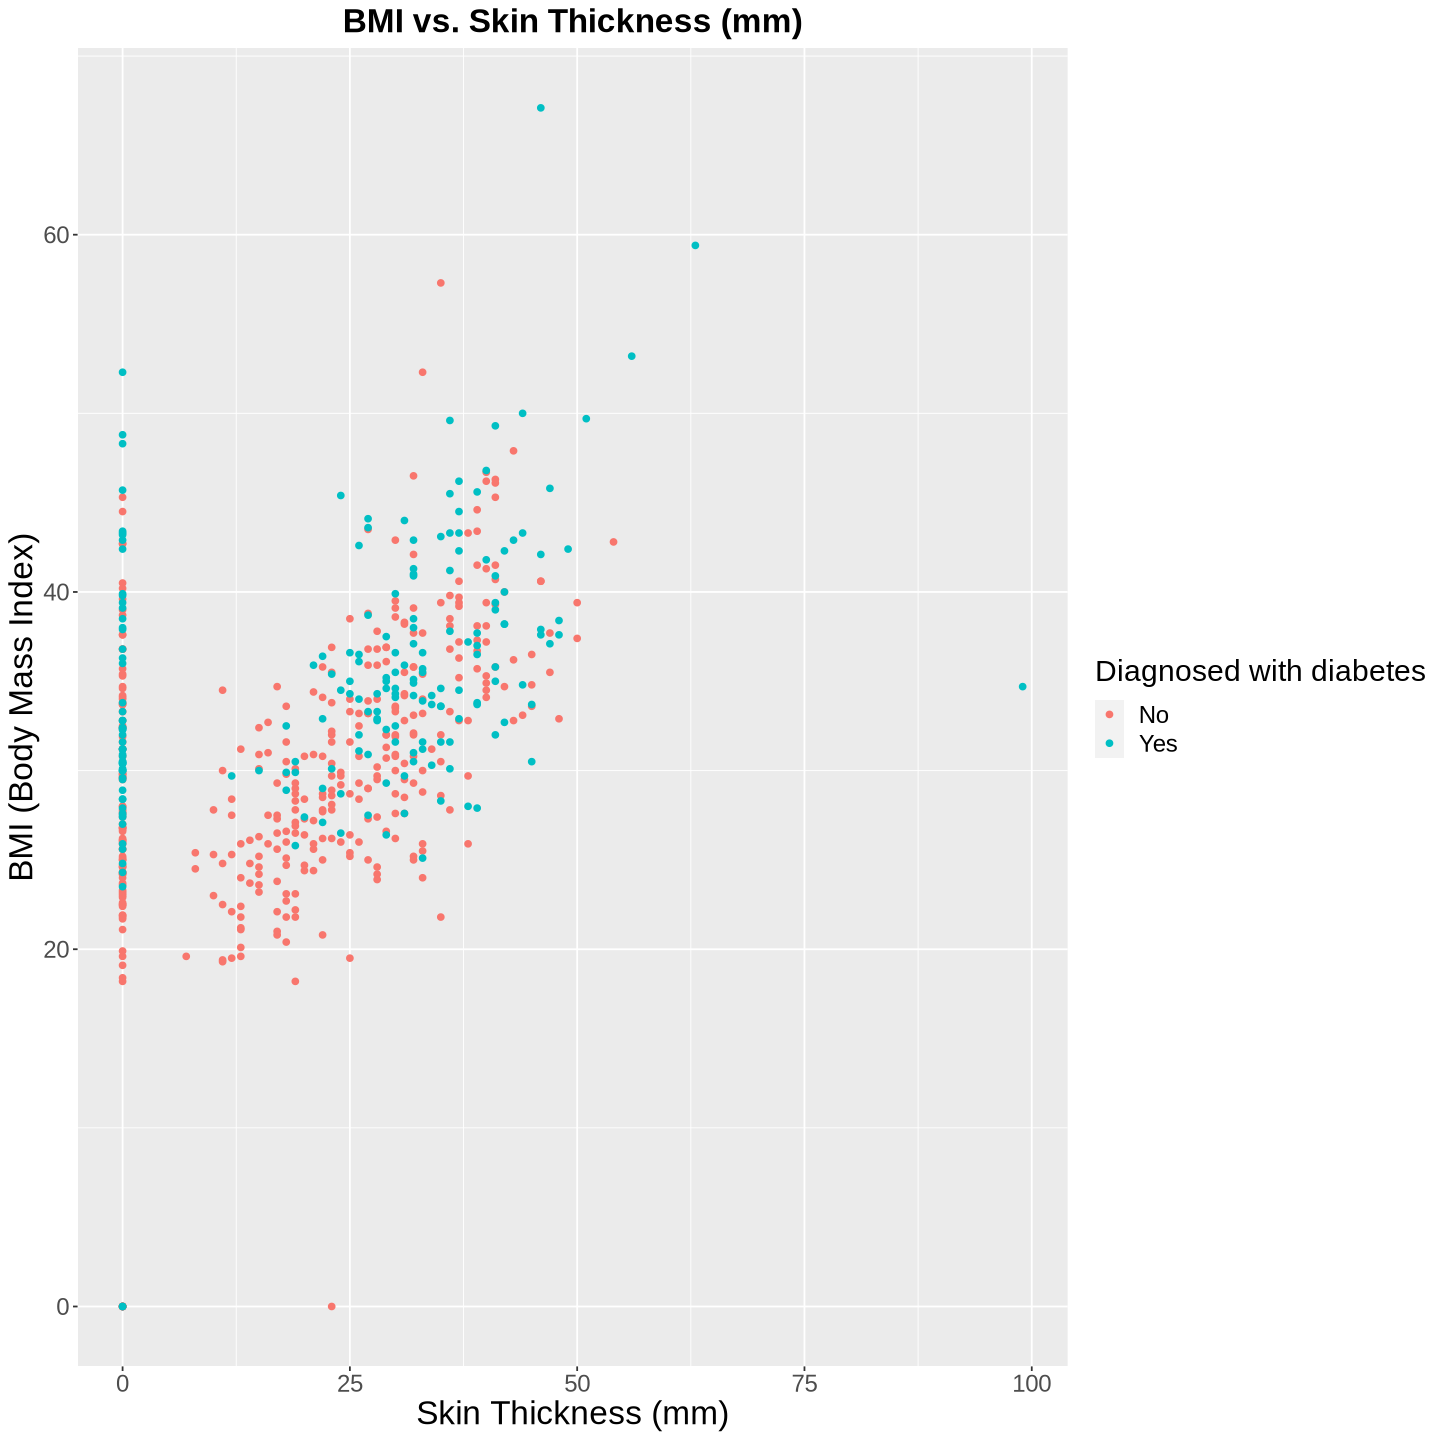

In [14]:
options(repr.plot.width = 12, repr.plot.height = 12)

diabetes_age_plot <- diabetes_training |>
                    ggplot(aes(x = skin_thickness, y = bmi, color = diabetes)) +
                    geom_point(alpha = 1.5) +
                    xlab("Skin Thickness (mm)") +
                    ylab("BMI (Body Mass Index)") +
                    labs(color = "Diagnosed with diabetes") +
                    ggtitle("BMI vs. Skin Thickness (mm)") +
                    theme(text = element_text(size = 18),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 20),
                          axis.title.y = element_text(size = 20))

diabetes_age_plot

**FIGURE 1**

In [ ]:
options(repr.plot.height = 12, repr.plot.width = 12)

diabetes_pressure_plot <- diabetes_training |> 
    ggplot(aes(x = pregnancies, y = blood_pressure, fill=diabetes)) + 
    geom_histogram(stat="identity") + 
    labs(x = "Pregnancies",
         y = "Diastolic blood pressure (mm Hg)",
         title = "Blood Pressure Distribution With Respect To Pregnancies",
         fill = "Diagnosed with diabetes") +
    facet_grid(cols = vars(diabetes)) +
    theme(text = element_text(size = 24),
                          plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
                          axis.title.x = element_text(size = 20),
                          axis.title.y = element_text(size = 20))
diabetes_pressure_plot

Warning message in geom_histogram(stat = "identity"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


**FIGURE 2**

### Methods

Based on the dataset source in **kaggle** (https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database), we can classify the columns as below:

1. **pregnancies** - Number of times pregnant 
2. **glucose** - Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. **blood pressure** - Diastolic blood pressure (mm Hg)
4. **skin thickness** - Triceps skin fold thickness (mm)
5. **insulin** - 2-Hour serum insulin (mu U/ml)
6. **bmi** - Body mass index (weight in kg/(height in m)^2)
7. **diabetic pedigree function** - Diabetes pedigree function
8. **age** - Age (years)
9. **diabetes** - Class variable (0 or 1) 268 of 768 are 1, the others are 0

We will conduct this data analysis by examining the relationships of glucose concentration, BMI, blood pressure, age and number of pregnancies to the diagnosis of diabetes. We can determine the relationships and compare the strength to determine what health factors contributes and is prevalent in a positive diabetes diagnosis. These variables are useful for our predictions based on some preliminary analysis and trends developed in the plots above. 

To visualize the results, we would initially create a scatter plot to discover the relationship (linear, strong, etc) between the predictors. After predicting on the testing set, we would be able to see the prediction results in a table. Furthermore, we could use a bar plot to visualize and compare the different precision, accuracy, and recall for various K values.

### Expected Outcomes and Significance

Expectations
1. Blood pressure and number of pregnancies impact the likelihood of diabetes.
2. There is positive relationship between diabetes and BMI.
3. High age and glucose concentration increase the likelihood of diabetes. 

Impact

1. Visualize if BMI level and blood pressure influences the likelihood of diabetes. 
2. Determine what variables related to diabetes medical workers must focus on to decrease the risk of diabetes diagnosis. 
3. Determining the critical age range where individuals are more susceptible to developing diabetes based on glucose levels. 

Future Questions
1. What trait should doctors monitor for highly diabetic patients?
2. At what age should individuals closely monitor their glucose level?
3. Should pregnant women be more cautious towards diabetes?

### Bibliography

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.